<a href="https://colab.research.google.com/github/abdellah-idris/NLI/blob/master/cross%2Bhierarchical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

rendu: zip

final: fcihier a anoter ( text et mettre les labels)

repport : pdf, on vas dans le concret ( moins de blabla)
  -  carnet d'experience ( ce qu'on a tester)
  -  expliciter ce qui n'a pas marché
  -  essayer de faire des conclusion

Presentation:
  - parler d'un truc intéressant et parler rapidement (cross vs grip) 5 a 10 max


date d'envoi max 04/07
mail : @universite-paris-saclay

### **1. Importation des librairies**

In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from collections import Counter

### **2. Lecture des données**

In [2]:
from google.colab import files

uploaded = files.upload()


Saving train.txt to train.txt


In [3]:
os.listdir('.')

['.config', 'model+vec', '.ipynb_checkpoints', 'train.txt', 'sample_data']

In [4]:
df = pd.read_csv('train.txt', sep='\t', header=None)

In [5]:
def extract_country_and_text(row):
    match = re.match(r'\((.*?)\)(.*)', row)
    if match:
        country_code = match.group(1)
        text = match.group(2)
        return pd.Series([country_code, text])
    else:
        return pd.Series(['', row])

df[['country_code', 'text']] = df.iloc[:, 0].apply(extract_country_and_text)

df['country_code'].value_counts()

GER    900
TUR    900
CHI    900
TEL    900
ARA    900
SPA    900
HIN    900
JPN    900
KOR    900
FRE    900
ITA    900
Name: country_code, dtype: int64

### **Utils**

#### models & vectorizers

In [6]:
groups_mapping= {'HIN+TEL':0, 'KOR+CHI+JPN':1, 'FRE+SPA+ITA+GER':2,'ARA+TUR':3}

In [7]:
# vectorizers
vectorizers = {
  'vectorizer_BOW' : CountVectorizer(), # default=(1, 1)
  'vectorizer_TF_IDF' : TfidfVectorizer(), #default=(1, 1)
  'vectorizer_BOW_bigram' : CountVectorizer(ngram_range=(1, 2)),
  'vectorizer_TF_IDF_bigram' : TfidfVectorizer(ngram_range=(1, 2)),
}

# Modèles de classification
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'SVM': SVC()
}

#### Balance data
- each group same number of item
- in each group: each country same number of item

In [8]:
import pandas as pd

def balance_dataset_groups(df):
    balanced_df = pd.DataFrame(columns=df.columns)

    # Determine the minimum number of samples among all groups
    min_samples_per_group = df['group'].value_counts().min()

    # Iterate over each group in the dataset
    for group_name, group_data in df.groupby('group'):
        # Sample the minimum number of samples for this group
        sampled_group_data = group_data.sample(min_samples_per_group, replace=False)

        # Determine the minimum number of samples among all subgroups within this group
        min_samples_per_subgroup = min_samples_per_group // len(group_data['country_code'].unique())

        # Iterate over each subgroup within this group
        for subgroup_name, subgroup_data in sampled_group_data.groupby('country_code'):
            # Determine the number of samples in this subgroup
            subgroup_size = len(subgroup_data)

            # If the subgroup has fewer samples than required, sample with replacement
            if subgroup_size < min_samples_per_subgroup:
                sampled_subgroup_data = subgroup_data.sample(min_samples_per_subgroup, replace=True)
            else:
                sampled_subgroup_data = subgroup_data.sample(min_samples_per_subgroup, replace=False)

            # Append the sampled subgroup data to the balanced dataset
            balanced_df = pd.concat([balanced_df, sampled_subgroup_data])

    # Reset the index of the balanced DataFrame
    balanced_df.reset_index(drop=True, inplace=True)

    return balanced_df


#### Fonctions d'évaluations et matrice de confusion :

In [9]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def evaluate_model_performance_detailed(mapping_list, model, model_name, method_name, train, test, y_train, y_test):
    model.fit(train, y_train)
    predictions = model.predict(test)

    # Metrics for each label
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average=None)
    metrics_df = pd.DataFrame({'Label': list(mapping_list.keys()),
                               'Precision': precision,
                               'Recall': recall,
                               'F1 Score': f1})

    # Global (macro) metrics
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, predictions, average='macro')
    accuracy = accuracy_score(y_test, predictions)

    print(f"{model_name} ({method_name}) - Overall Metrics:\n- Accuracy: {accuracy:.4f}\n- Precision (Macro): {precision_macro:.4f}\n- Recall (Macro): {recall_macro:.4f}\n- F1 (Macro): {f1_macro:.4f}\n")

    print(f"{model_name} ({method_name}) - Metrics by Label:")
    print(metrics_df.to_string(index=False))


    cm = confusion_matrix(y_test, predictions)

    # Plotting the confusion matrix
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='d', xticklabels=list(mapping_list.keys()), yticklabels=list(mapping_list.keys()))
    plt.title(f"Confusion Matrix - {model_name} ({method_name})")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    return model


#### extract country and text

In [10]:
df.dropna(subset=['country_code'], inplace=True)
df.shape

# All texts are labeled

(9900, 3)

In [11]:
def extract_country_and_text(row):
    match = re.match(r'\((.*?)\)(.*)', row)
    if match:
        country_code = match.group(1)
        text = match.group(2)
        return pd.Series([country_code, text])
    else:
        return pd.Series(['', row])

df[['country_code', 'text']] = df.iloc[:, 0].apply(extract_country_and_text)

df['country_code'].value_counts()

GER    900
TUR    900
CHI    900
TEL    900
ARA    900
SPA    900
HIN    900
JPN    900
KOR    900
FRE    900
ITA    900
Name: country_code, dtype: int64

#### create groups

In [12]:
def create_group(df):
  # Créez une nouvelle colonne 'Country_Code_New4' en copiant 'Country_Code'
  df['group'] = df['country_code']

  df.loc[df['country_code'].isin(['TEL', 'HIN']), 'group']  = 'HIN+TEL'
  df.loc[df['country_code'].isin(['KOR', 'CHI','JPN']), 'group'] = 'KOR+CHI+JPN'
  df.loc[df['country_code'].isin(['FRE', 'SPA','ITA','GER']), 'group'] = 'FRE+SPA+ITA+GER'
  df.loc[df['country_code'].isin(['ARA', 'TUR']), 'group'] = 'ARA+TUR'

  return df

In [13]:
create_group(df)

,0,country_code,text,group
0,(GER) IThe importance and popularity of travel...,GER,IThe importance and popularity of travelling ...,FRE+SPA+ITA+GER
1,"(TUR) It is an important decision , how to pla...",TUR,"It is an important decision , how to plan you...",ARA+TUR
2,(CHI) Some people believe that young people ca...,CHI,Some people believe that young people can enj...,KOR+CHI+JPN
3,(TEL) Travelling is usually considered as good...,TEL,Travelling is usually considered as good recr...,HIN+TEL
4,(ARA) i agree that . Life is a person live per...,ARA,i agree that . Life is a person live period o...,ARA+TUR
...,...,...,...,...
9895,"(CHI) Nowadays , more and more people go abroa...",CHI,"Nowadays , more and more people go abroad , n...",KOR+CHI+JPN
9896,(KOR) In accomplishing something that is risky...,KOR,In accomplishing something that is risky come...,KOR+CHI+JPN
9897,"(SPA) At the beginning of the 21st century , t...",SPA,"At the beginning of the 21st century , the in...",FRE+SPA+ITA+GER
9898,(HIN) The number of cars in use across the wor...,HIN,The number of cars in use across the world ha...,HIN+TEL


#### groups_dataframes

In [14]:
# get Dict by groups
def create_groups_dataframes(df):
  groups_labels = {'HIN+TEL', 'KOR+CHI+JPN', 'FRE+SPA+ITA+GER','ARA+TUR'}
  groups_dataframes = {}

  for label in groups_labels:
      label_df = df[df['group'] == label]  # Replace 'label_column' with the actual column name
      groups_dataframes[label] = label_df

  return groups_dataframes

In [15]:
# get dict by country in each group
def create_1_group_dataframes(df, country_labels):
  groups_dataframes = {}
  for label in country_labels:
      label_df = df[df['country_code'] == label]  # Replace 'label_column' with the actual column name
      groups_dataframes[label] = label_df

  return groups_dataframes

#### shuffle_rows

In [16]:
def shuffle_rows(dfs): # mélange des données
    i = 0
    for df in dfs:
      dfs[i] = df.sample(frac = 1, random_state=42)
      i += 1

#### train

In [17]:
def train(mapping_list, df, save_model_vectorizer):
  X = df['text']
  y_grouped4 = df['group'].map(mapping_list)

  # Entraînement et évaluation des modèles
  for model_name, model in models.items():
      for vectorizer_name, vectorizer in vectorizers.items():
          print('========================= Model: {}; vectorizer: {} ========================='.format(model_name, vectorizer))
          train, test, y_train_grouped4, y_test_grouped4 = train_test_split(vectorizer.fit_transform(X), y_grouped4, test_size=0.2, random_state=42)
          model_save = evaluate_model_performance_detailed(groups_mapping, model, model_name, vectorizer_name, train, test, y_train_grouped4, y_test_grouped4)
          save_model_vectorizer[model_name+'-'+vectorizer_name]  = (model_save, vectorizer)

In [18]:
def train_1_group(mapping_list, df, save_model_vectorizer):
  X = df['text']
  print(X.shape)
  y_grouped4 = df['country_code'].map(mapping_list)
  print(y_grouped4.shape)

  # Entraînement et évaluation des modèles
  for model_name, model in models.items():
      for vectorizer_name, vectorizer in vectorizers.items():
          print('========================= Model: {}; vectorizer: {} ========================='.format(model_name, vectorizer))
          train, test, y_train_grouped4, y_test_grouped4 = train_test_split(vectorizer.fit_transform(X), y_grouped4, test_size=0.2, random_state=42)
          model_save = evaluate_model_performance_detailed(mapping_list, model, model_name, vectorizer_name, train, test, y_train_grouped4, y_test_grouped4)
          save_model_vectorizer[model_name+'-'+vectorizer_name]  = (model_save, vectorizer)

#### best model

In [19]:
def best(results):
  best = max(results, key=lambda key: results[key]['test_accuracy'])
  return best

##  **3. Regroupement**:

  - **Groupe 01**: TEL, HIN
  - **Groupe 02**: KOR, CHI, JPN
  - **Groupe 03**: FRE, SPA, ITA, GER
  - **Groupe 04**: ARA, TUR

#### Unbalanced

In [20]:
unbalanced_models = {}
train(groups_mapping, df, unbalanced_models)

========================= Model: Logistic Regression; vectorizer: CountVectorizer() =========================


KeyboardInterrupt: 

Best model

In [ ]:
unbalanced_models

#### Balanced

In [21]:
# Balance the dataset
balanced_df = balance_dataset_groups(df)

# Verify the balance
print(balanced_df['group'].value_counts())
print(balanced_df.groupby(['group', 'country_code']).size())

ARA+TUR            1800
FRE+SPA+ITA+GER    1800
HIN+TEL            1800
KOR+CHI+JPN        1800
Name: group, dtype: int64
group            country_code
ARA+TUR          ARA             900
                 TUR             900
FRE+SPA+ITA+GER  FRE             450
                 GER             450
                 ITA             450
                 SPA             450
HIN+TEL          HIN             900
                 TEL             900
KOR+CHI+JPN      CHI             600
                 JPN             600
                 KOR             600
dtype: int64


In [ ]:
balanced_models = {}
train(groups_mapping, balanced_df, balanced_models)

In [ ]:
balanced_models

# 4. cross validation functions

##### Utils

In [22]:
# separate the dataframe into labels
balanced_df = balanced_df.iloc[: , 1:]

In [23]:
labels = {"GER","TUR","CHI","TEL","ARA","SPA","HIN","JPN","KOR","FRE","ITA"}

In [24]:
label_dataframes = {}

for label in labels:
    label_df = df[df['country_code'] == label]  # Replace 'label_column' with the actual column name
    label_dataframes[label] = label_df

In [25]:
groups_df = create_groups_dataframes(balanced_df)

In [26]:
groups_df.keys()

dict_keys(['HIN+TEL', 'FRE+SPA+ITA+GER', 'KOR+CHI+JPN', 'ARA+TUR'])

In [27]:
groups_df['HIN+TEL'].shape

(1800, 3)

##### splits

In [28]:
def splits(label_dataframes, split_nbr):
    size = 1800
    max = 100

    trains = []
    devs = []
    tests = []

    start = 0
    end = size // split_nbr if split_nbr != 0 and size // split_nbr < max else max

    while split_nbr != 0:
        split_nbr -= 1

        train_splits = []
        dev_splits = []
        test_splits = []

        for df in label_dataframes.values():
            test_split = df[start:end]
            dev_split = df[end:end + (end - start)]  # Set dev_split size to (end - start)
            train_split = df[end + (end - start):]    # The remaining data goes to test_split

            train_splits.append(train_split)
            dev_splits.append(dev_split)
            test_splits.append(test_split)

        trains.append(pd.concat(train_splits))
        devs.append(pd.concat(dev_splits))
        tests.append(pd.concat(test_splits))

        start = end
        end = start + (size // split_nbr) if split_nbr != 0 and (size // split_nbr) < max else (start + max)

    return trains, devs, tests


##### test indexes

In [29]:
def test_diffrent_indexes(dfs):
    # Initialize a variable to track if indexes are different
    different_indexes = False

    # Iterate through pairs of DataFrames and compare indexes
    for i in range(len(dfs) - 1):
        for j in range(i + 1, len(dfs)):
            if not dfs[i].index.equals(dfs[j].index):
                different_indexes = True
                break
        if different_indexes:
            break

    # Output the result
    if different_indexes:
        print("The DataFrames have different indexes.")
    else:
        print("The DataFrames have the same indexes.")

In [30]:
trains, devs, tests = splits(groups_df, 3)

In [31]:
test_diffrent_indexes(devs), test_diffrent_indexes(tests)

The DataFrames have different indexes.
The DataFrames have different indexes.


(None, None)

In [32]:
shuffle_rows(trains), shuffle_rows(tests), shuffle_rows(devs)

(None, None, None)

In [33]:
trains[0].shape[0], devs[0].shape[0], tests[0].shape[0],

(6400, 400, 400)

##### cross validation

In [34]:
from sklearn.model_selection import cross_val_score, ParameterGrid
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import time

def cross_validation(mapping_list, df, model, params, vectorizer, split=3):
    # split data: train, dev, test
    trains, devs, tests = splits(df, split)

    param_grid = ParameterGrid(params)
    results = {}

    for param in param_grid:
        iteration = 0
        accuracies = []
        test_accuracies=[]
        print(param)

        model.set_params(**param)  # set model parameters
        print(model)

        for train, dev, test in zip(trains, devs, tests):
            start = time.time()
            iteration += 1
            print(iteration)

            # Feature extraction for text
            vectorizer.fit(train['text'])
            X_train_text = vectorizer.transform(train['text'])
            X_dev_text = vectorizer.transform(dev['text'])
            X_test_text = vectorizer.transform(test['text'])


            # Train the model on the training set
            model.fit(X_train_text, train['group'].map(mapping_list))

            # Validate the model on the dev set
            accuracy = model.score(X_dev_text, dev['group'].map(mapping_list))
            accuracies.append(accuracy)

            # Evaluate the model on the test set
            test_accuracy = model.score(X_test_text, test['group'].map(mapping_list))
            test_accuracies.append(test_accuracy)

            print("Dev Accuracy= " + str(accuracy))
            print("Test Accuracy= " + str(test_accuracy))
            print("time spent=" + str((time.time()-start)/60))

        results[str(param)] = {
            "model": model.set_params(**param),
            "vectorizer": vectorizer,
            'dev_mean_accuracy': sum(accuracies) / len(accuracies),
            'test_accuracy': sum(test_accuracies) / len(test_accuracies),
        }

    return results

In [35]:

def cross_validation_1group(mapping_list, df, model, params, vectorizer, split=3):
    # split data: train, dev, test
    trains, devs, tests = splits(df, split)

    param_grid = ParameterGrid(params)
    results = {}

    for param in param_grid:
        iteration = 0
        accuracies = []
        test_accuracies=[]
        print(param)

        # Train the model on the training set
        model.set_params(**param)  # set model parameters
        print(model)

        for train, dev, test in zip(trains, devs, tests):
            start = time.time()
            iteration += 1
            print(iteration)

            # Feature extraction for text
            vectorizer.fit(train['text'])
            X_train_text = vectorizer.transform(train['text'])
            X_dev_text = vectorizer.transform(dev['text'])
            X_test_text = vectorizer.transform(test['text'])


            model.fit(X_train_text, train['country_code'].map(mapping_list))

            # Validate the model on the dev set
            accuracy = model.score(X_dev_text, dev['country_code'].map(mapping_list))
            accuracies.append(accuracy)

            # Evaluate the model on the test set
            test_accuracy = model.score(X_test_text, test['country_code'].map(mapping_list))
            test_accuracies.append(test_accuracy)

            print("Dev Accuracy= " + str(accuracy))
            print("Test Accuracy= " + str(test_accuracy))
            print("time spent=" + str((time.time()-start)/60))

        results[str(param)] = {
            "model": model.set_params(**param),
            "vectorizer": vectorizer,
            'dev_mean_accuracy': sum(accuracies) / len(accuracies),
            'test_accuracy': sum(test_accuracies) / len(test_accuracies),
        }

    return results

##### save & load model

In [36]:
import pickle

def save_model_vectorizer(model, vectorizer, model_name, vectorizer_name):
    pickle.dump(model, open(model_name, 'wb'))
    pickle.dump(vectorizer, open(vectorizer_name, 'wb'))

In [37]:
def load(filename):
    return  pickle.load(open(filename, 'rb'))

# 5. Cross validation first model M1

## Grids and models

In [38]:
lr_model = LogisticRegression()
lr_param_grid = {
    'penalty': ['l2'],  # Regularization penalty
    'C': [0.01, 1],  # Inverse regularization strength (reduced to two values)
    'solver': ['liblinear', 'saga'],  # Algorithm to use in the optimization problem
    'max_iter': [1500],  # Maximum number of iterations (reduced to one value)
    'tol': [1e-4]  # Tolerance for stopping criteria (only one value)
}

##LogisticRegression



In [39]:
results = cross_validation(groups_df, lr_model, lr_param_grid, vectorizers['vectorizer_BOW_bigram'], 2)

AttributeError: 'LogisticRegression' object has no attribute 'values'

In [ ]:
results

In [ ]:
# Find the key with the best test accuracy
best_accuracy_key = max(results, key=lambda key: results[key]['test_accuracy'])
print("Key with best test accuracy:", best_accuracy_key)

In [ ]:
results[best_accuracy_key]["test_accuracy"]

In [ ]:
# cross validation model
M1 = results[best_accuracy_key]["model"]
V1 = results[best_accuracy_key]["vectorizer"]

In [ ]:
save_model_vectorizer(M1, V1, "M1.sav", "V1.pkl")

# Cross validation specialized model M2

## Utils

#### extract groups

In [40]:
def extract_group(df, group):
  return df[df['group'] == group]

### mapping country

In [41]:
def mapping(df, mapping):
  df['country_code'].map(mapping)

## Model for  Groupe 1 HIN+TEL


In [42]:
df_g1 = extract_group(df, 'HIN+TEL')

In [43]:
df_g1

,0,country_code,text,group
3,(TEL) Travelling is usually considered as good...,TEL,Travelling is usually considered as good recr...,HIN+TEL
8,"(HIN) In the era of science and technology , t...",HIN,"In the era of science and technology , the pe...",HIN+TEL
21,(TEL) Yup ! i do agree with is statement that ...,TEL,Yup ! i do agree with is statement that most ...,HIN+TEL
26,(TEL) I do agree with the satement that `` You...,TEL,I do agree with the satement that `` Young pe...,HIN+TEL
37,(HIN) Everybody has its own point of view on a...,HIN,Everybody has its own point of view on a cert...,HIN+TEL
...,...,...,...,...
9882,(HIN) I agree with the opinion thjat young pro...,HIN,I agree with the opinion thjat young prople o...,HIN+TEL
9886,(TEL) yes i agree with the statemet given abov...,TEL,yes i agree with the statemet given above . A...,HIN+TEL
9889,(HIN) I support the argument that young people...,HIN,I support the argument that young people do n...,HIN+TEL
9890,(HIN) This is a difficult topis as both travel...,HIN,This is a difficult topis as both travelling ...,HIN+TEL


#### train

(1800,)
(1800,)
========================= Model: Logistic Regression; vectorizer: CountVectorizer() =========================
Logistic Regression (vectorizer_BOW) - Overall Metrics:
- Accuracy: 0.7611
- Precision (Macro): 0.7626
- Recall (Macro): 0.7617
- F1 (Macro): 0.7610

Logistic Regression (vectorizer_BOW) - Metrics by Label:
Label  Precision   Recall  F1 Score
  HIN   0.738220 0.796610  0.766304
  TEL   0.786982 0.726776  0.755682


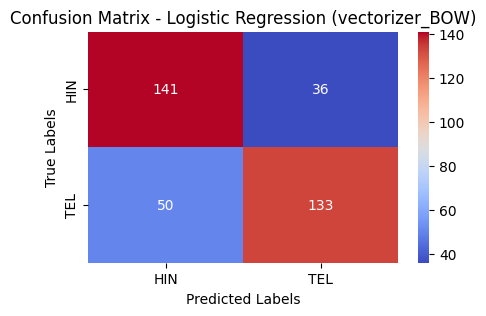

========================= Model: Logistic Regression; vectorizer: TfidfVectorizer() =========================
Logistic Regression (vectorizer_TF_IDF) - Overall Metrics:
- Accuracy: 0.7500
- Precision (Macro): 0.7502
- Recall (Macro): 0.7502
- F1 (Macro): 0.7500

Logistic Regression (vectorizer_TF_IDF) - Metrics by Label:
Label  Precision   Recall  F1 Score
  HIN   0.737705 0.762712      0.75
  TEL   0.762712 0.737705      0.75


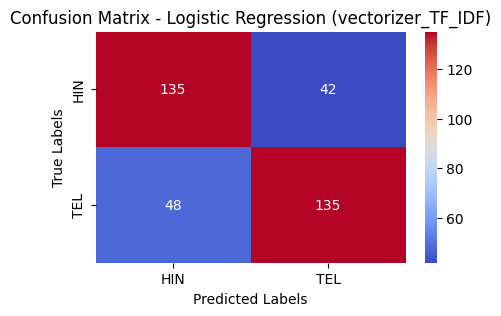

========================= Model: Logistic Regression; vectorizer: CountVectorizer(ngram_range=(1, 2)) =========================
Logistic Regression (vectorizer_BOW_bigram) - Overall Metrics:
- Accuracy: 0.7750
- Precision (Macro): 0.7763
- Recall (Macro): 0.7755
- F1 (Macro): 0.7749

Logistic Regression (vectorizer_BOW_bigram) - Metrics by Label:
Label  Precision   Recall  F1 Score
  HIN   0.752632 0.807910  0.779292
  TEL   0.800000 0.743169  0.770538


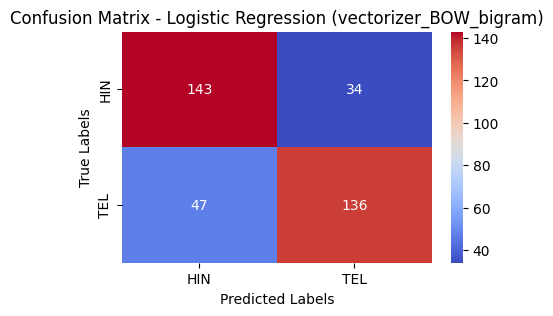

========================= Model: Logistic Regression; vectorizer: TfidfVectorizer(ngram_range=(1, 2)) =========================
Logistic Regression (vectorizer_TF_IDF_bigram) - Overall Metrics:
- Accuracy: 0.7667
- Precision (Macro): 0.7669
- Recall (Macro): 0.7669
- F1 (Macro): 0.7667

Logistic Regression (vectorizer_TF_IDF_bigram) - Metrics by Label:
Label  Precision   Recall  F1 Score
  HIN   0.754098 0.779661  0.766667
  TEL   0.779661 0.754098  0.766667


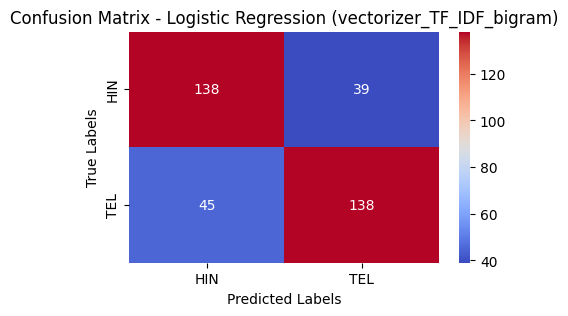

========================= Model: SVM; vectorizer: CountVectorizer() =========================
SVM (vectorizer_BOW) - Overall Metrics:
- Accuracy: 0.7250
- Precision (Macro): 0.7251
- Recall (Macro): 0.7252
- F1 (Macro): 0.7250

SVM (vectorizer_BOW) - Metrics by Label:
Label  Precision   Recall  F1 Score
  HIN   0.714286 0.734463  0.724234
  TEL   0.735955 0.715847  0.725762


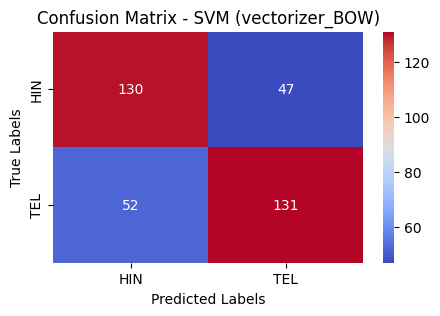

========================= Model: SVM; vectorizer: TfidfVectorizer() =========================
SVM (vectorizer_TF_IDF) - Overall Metrics:
- Accuracy: 0.7639
- Precision (Macro): 0.7667
- Recall (Macro): 0.7647
- F1 (Macro): 0.7636

SVM (vectorizer_TF_IDF) - Metrics by Label:
Label  Precision   Recall  F1 Score
  HIN   0.734694 0.813559  0.772118
  TEL   0.798780 0.715847  0.755043


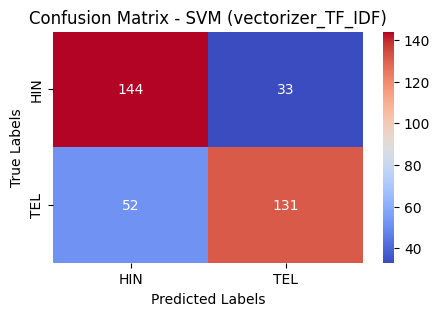

========================= Model: SVM; vectorizer: CountVectorizer(ngram_range=(1, 2)) =========================
SVM (vectorizer_BOW_bigram) - Overall Metrics:
- Accuracy: 0.7528
- Precision (Macro): 0.7536
- Recall (Macro): 0.7532
- F1 (Macro): 0.7527

SVM (vectorizer_BOW_bigram) - Metrics by Label:
Label  Precision   Recall  F1 Score
  HIN   0.734043 0.779661  0.756164
  TEL   0.773256 0.726776  0.749296


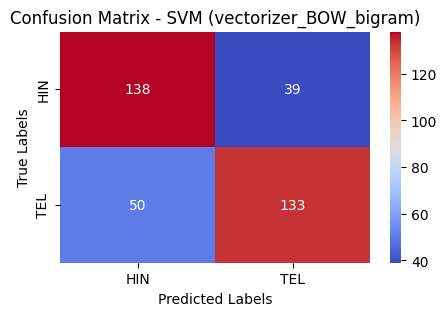

========================= Model: SVM; vectorizer: TfidfVectorizer(ngram_range=(1, 2)) =========================
SVM (vectorizer_TF_IDF_bigram) - Overall Metrics:
- Accuracy: 0.7583
- Precision (Macro): 0.7633
- Recall (Macro): 0.7594
- F1 (Macro): 0.7577

SVM (vectorizer_TF_IDF_bigram) - Metrics by Label:
Label  Precision   Recall  F1 Score
  HIN   0.722772 0.824859  0.770449
  TEL   0.803797 0.693989  0.744868


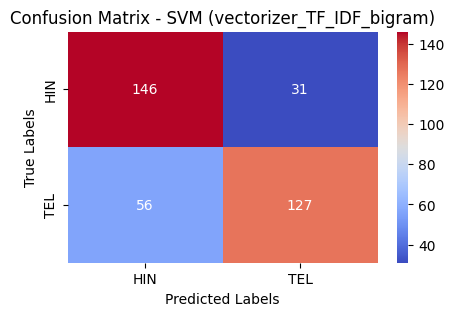

In [44]:
models_g1 = {}
mapping_list1 = {'HIN':0,'TEL':1}
train_1_group(mapping_list1, df_g1, models_g1) # mapping is done here

### cross

In [45]:
dict_df1 = create_1_group_dataframes(balanced_df, {'HIN', 'TEL'})

In [46]:
results = cross_validation_1group(mapping_list1, dict_df1, lr_model, lr_param_grid, vectorizers['vectorizer_BOW_bigram'], 2)

{'C': 0.01, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
LogisticRegression(C=0.01, max_iter=1500, solver='liblinear')
1
Dev Accuracy= 0.81
Test Accuracy= 0.76
time spent=0.06669093370437622
2
Dev Accuracy= 0.73
Test Accuracy= 0.8
time spent=0.050340127944946286
{'C': 0.01, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.0001}
LogisticRegression(C=0.01, max_iter=1500, solver='saga')
1
Dev Accuracy= 0.81
Test Accuracy= 0.765
time spent=0.07483869393666585
2
Dev Accuracy= 0.725
Test Accuracy= 0.8
time spent=0.06728739341100057
{'C': 1, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
LogisticRegression(C=1, max_iter=1500, solver='liblinear')
1
Dev Accuracy= 0.81
Test Accuracy= 0.755
time spent=0.07287877798080444
2
Dev Accuracy= 0.73
Test Accuracy= 0.78
time spent=0.05139013528823853
{'C': 1, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.0001}
LogisticRegression(C=1, max_iter=1500, solver='saga')
1
Dev Accu

In [47]:
best_accuracy_key = best(results)

In [48]:
best_accuracy_key

"{'C': 0.01, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.0001}"

In [49]:
results[best_accuracy_key]

{'model': LogisticRegression(C=1, max_iter=1500, solver='saga'),
 'vectorizer': CountVectorizer(ngram_range=(1, 2)),
 'dev_mean_accuracy': 0.7675000000000001,
 'test_accuracy': 0.7825}

In [50]:
best_accuracy_key = best(results)
# cross validation model
M_G1 = results[best_accuracy_key]["model"]
V_G1 = results[best_accuracy_key]["vectorizer"]
save_model_vectorizer(M_G1, V_G1, "M_G1.sav", "V_G1.pkl")

## Model for  Groupe 2 'KOR+CHI+JPN'


In [51]:
df_g2 = extract_group(df,'KOR+CHI+JPN')

In [52]:
df_g2.head()

,0,country_code,text,group
2,(CHI) Some people believe that young people ca...,CHI,Some people believe that young people can enj...,KOR+CHI+JPN
9,(JPN) I agree with this statement . I think th...,JPN,I agree with this statement . I think that in...,KOR+CHI+JPN
10,"(KOR) Today , the method of teaching is mainly...",KOR,"Today , the method of teaching is mainly disc...",KOR+CHI+JPN
11,"(CHI) according to this statment , i think tha...",CHI,"according to this statment , i think that stu...",KOR+CHI+JPN
16,(JPN) Some people say that broad knowledge is ...,JPN,Some people say that broad knowledge is bette...,KOR+CHI+JPN


#### train

In [ ]:
models_g2 = {}
mapping_list2 = {'KOR':0, 'CHI':1, 'JPN':2}
train_1_group(mapping_list2, df_g2, models_g2) # mapping is done here

(2700,)
(2700,)
========================= Model: Logistic Regression; vectorizer: CountVectorizer() =========================


### cross

In [ ]:
dict_df2 = create_1_group_dataframes(balanced_df, {'KOR', 'CHI', "JAP"})

In [ ]:
results = cross_validation_1group(mapping_list2, dict_df2, lr_model, lr_param_grid, vectorizers['vectorizer_BOW_bigram'], 2)

In [ ]:
best_accuracy_key = best(results)

In [ ]:
best_accuracy_key

In [ ]:
results[best_accuracy_key]

In [ ]:
# cross validation model
M_G2 = results[best_accuracy_key]["model"]
V_G2 = results[best_accuracy_key]["vectorizer"]
save_model_vectorizer(M_G2, V_G1, "M_G2.sav", "V_G2.pkl")

In [ ]:
results[best_accuracy_key]['test_accuracy']

## Model for  Groupe 3 'FRE+SPA+ITA+'GER'



In [ ]:
df_g3 = extract_group(df, 'FRE+SPA+ITA+GER')

In [ ]:
df_g3.head()

#### train

In [ ]:
models_g3 = {}
mapping_list3 = {'FRE':0,'SPA':1,'ITA':2, 'GER':3 }
train_1_group(mapping_list3, df_g3, models_g3) # mapping is done here

### cross

In [ ]:
dict_df3 = create_1_group_dataframes(balanced_df, {'FRE', 'SPA', "ITA", "GER"})

In [ ]:
results = cross_validation_1group(mapping_list3, dict_df3, lr_model, lr_param_grid, vectorizers['vectorizer_BOW_bigram'], 2)

In [ ]:
best_accuracy_key = best(results)

In [ ]:
best_accuracy_key

In [ ]:
results[best_accuracy_key]

In [ ]:
# cross validation model
M_G3 = results[best_accuracy_key]["model"]
V_G3 = results[best_accuracy_key]["vectorizer"]
save_model_vectorizer(M_G3, V_G3, "M_G3.sav", "V_G3.pkl")

In [ ]:
results[best_accuracy_key]['test_accuracy']

## Model for  Groupe 4 ARA+TUR

In [ ]:
df_g4 = extract_group(df, 'ARA+TUR')

In [ ]:
df_g4.head()

#### train

In [ ]:
models_g4 = {}
mapping_list4 = {'ARA':0,'TUR':1}
train_1_group(mapping_list4, df_g4, models_g4) # mapping is done here

### cross

In [ ]:
dict_df4 = create_1_group_dataframes(balanced_df, {'ARA', 'TUR'})

In [ ]:
dict_df4

In [ ]:
results = cross_validation_1group(mapping_list4, dict_df4, lr_model, lr_param_grid, vectorizers['vectorizer_BOW_bigram'], 2)

In [ ]:
best_accuracy_key = best(results)

In [ ]:
best_accuracy_key

In [ ]:
results

In [ ]:
results[best_accuracy_key]

In [ ]:
# cross validation model
M_G4 = results[best_accuracy_key]["model"]
V_G4 = results[best_accuracy_key]["vectorizer"]
save_model_vectorizer(M_G4, V_G4, "M_G4.sav", "V_G4.pkl")

In [ ]:
results

# Save to colab

In [ ]:
from google.colab import drive
drive.mount('/content/model+vec')